# IPL Powerplay Score Prediction
![IPL banner](https://cricketaddictor.gumlet.io/wp-content/uploads/2021/02/153757448_173638941016448_6980867142752435675_n.jpg?compress=true&quality=80&w=1920&dpr=2.6)

It's COVID lockdown time. Everyone is worried about the increasing COVID cases, Work From Home (WFH) environment. No way to go out, no parties, no outing, no vacation plans, no gatherings ...... 

Government announces Lockdown : 1.0, 2.0, 3.0, 4.0 .....

At that time every cricket fan had a question. 
> **"Do new Govt. rules in lockdown 4.0 pave the way for IPL 2020 ????"**



Finally IPL 2020 happend. 
* **Even pandamic situation can't derail the IPL juggernaut.**
* IPL 20202 earned revenue of : 4000 crores with 
  *  35% reduced cost and 
  *  25% increase in viewership. 

As a cricket fan I watch all the matches, during that time I observed that **"Powerplay plays a mojor role"** which is very Important in Team score.

## What is powerplay in IPL & it's Importance???
* In summary "powerplay" means fielding restrictions in 1<sup>st</sup> 6-overs.
  * means, only 2-fielders can stay outside the Inner-circle
  * After powerplay, upto 5-fielders can stay outside inner circle & 4-fielders must remain inside the inner circle.
* Which makes the **batting compatively easy.**
* Also **it's a trap for the batsmen**, as this will get them to take into a risk and loose their wickets in 1<sup>st</sup> 6-overs

## Effect of "Powerplay" in IPL matches??
* Powerplay overs are considered as pillars of any teams  victory.
* 75% - of winning chance of the team depends on the Powerplay score.
* So, every team's expectation from the top 3-batsmen is **"START THE INNINGS BIG"**

In this blog post I am going to predict the score of an IPL match at the end of powerplay.

In [2]:
import requests,zipfile,io,json
from pathlib import Path

#from sklearn.preprocessing import LabelEncoder
from collections import OrderedDict

import pandas as pd
import seaborn as sns
import numpy as np

import torch 

from matplotlib import pyplot as plt
%matplotlib inline

# **Variable Declaration:**

In [2]:
epochs      = 100
lr          = 1e-3
split_ratio = (70.0,30.0)
train_bs    = 64   # Then test_bs = 2*train_bs
pltName     = 'test14.png'
changeDescription   = 'SGD + Nestrove Momentum with LR = 1e-3 with batch size = 64'

seed = 143
torch.manual_seed(seed)

In [4]:
dataset_path = Path(Path.cwd(),'dataset')
snippets_path = Path(Path.cwd(),'snippets')
filename = 'all_matches.csv'
recordedMetrics = 'Recorded_Metrics.csv'

json_path = Path.joinpath(dataset_path, 'label_encode.json')

save_files = False
record = True

# **1.Loading the Data Set:** 

Dataset will be available at : https://cricsheet.org/downloads/ipl_male_csv.zip

In [4]:
def getCsvFile(url="https://cricsheet.org/downloads/ipl_male_csv2.zip"):
    res = requests.get(url, stream=True)
    if res.status_code == 200:
        print('### Downloading the CSV file')
        z = zipfile.ZipFile(io.BytesIO(res.content))
        if filename in z.namelist():
            z.extract(filename, dataset_path)
            print('### Extracted %s file' % filename)
        else:
            print('### %s : File not found in ZIP Artifact' % filename)

def downloadDataset():
    if not dataset_path.exists():
        Path.mkdir(dataset_path)
        print('### Created Dataset folder')
        getCsvFile()
    elif dataset_path.exists():
        files = [file for file in dataset_path.iterdir() if file.name ==
                 'all_matches.csv']
        if len(files) == 0:
            getCsvFile()
        else:
            print('### File already extracted in given path')
downloadDataset()

### File already extracted in given path


# **2. Data Frames:** 

In [5]:
csv_file=Path.joinpath(dataset_path, filename)

df = pd.read_csv(csv_file,parse_dates=['start_date'],low_memory=False)
df_parsed = df.copy(deep=True)
print(df.shape)
df.head()


(200664, 22)


,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
0,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,0.1,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,BB McCullum,...,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,0.2,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,0.3,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,...,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,0.4,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,0.5,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **3. Exploratory Data Analysis (EDA) / Data Processing:**
## 3.1: Identify "null" values in Dataset:

In [6]:
df.isnull().sum()

match_id                       0
season                         0
start_date                     0
venue                          0
innings                        0
ball                           0
batting_team                   0
bowling_team                   0
striker                        0
non_striker                    0
bowler                         0
runs_off_bat                   0
extras                         0
wides                     194583
noballs                   199854
byes                      200135
legbyes                   197460
penalty                   200662
wicket_type               190799
player_dismissed          190799
other_wicket_type         200664
other_player_dismissed    200664
dtype: int64

## 3.2: Cleaning Steps:
1. Here columns 'season' and 'start_date'  are not needed for our prediction. ```So we can drop the columns 'season' and 'start_date' from the dataset.```
2. Delete Non-existing teams : 
```
       'Kochi Tuskers Kerala' 'Pune Warriors','Rising Pune Supergiants', 'Rising Pune Supergiant','Gujarat Lions'
```
3. Replace the old team names with new team name:
```
      'Delhi Daredevils'  --> 'Delhi Capitals'
      'Deccan Chargers'   --> 'Sunrisers Hyderabad'
      'Punjab Kings'      --> 'Kings XI Punjab'
```

4. Correct the venue column with unique names. In this dataset same stadium is being represented as in multiple ways. So identify those and rename.
```
      ['M Chinnaswamy Stadium', 'M.Chinnaswamy Stadium']
      ['Brabourne Stadium', 'Brabourne Stadium, Mumbai']
      ['Punjab Cricket Association Stadium, Mohali', 'Punjab Cricket Association IS Bindra Stadium, Mohali', 'Punjab Cricket Association IS Bindra Stadium']
      ['Wankhede Stadium', 'Wankhede Stadium, Mumbai']
      ['Rajiv Gandhi International Stadium, Uppal', 'Rajiv Gandhi International Stadium']
      ['MA Chidambaram Stadium, Chepauk','MA Chidambaram Stadium',      'MA Chidambaram Stadium, Chepauk, Chennai']
```

5. Rename the column names (for easy coding)
```
      'striker'     --> 'batsmen'
      'non-striker' --> 'batsmen_nonstriker'  (This column is not required)
      'bowler'      --> 'bowlers'
```
      
6. Create a columns "Total_score" : which reflects the runs through bat and extra runs through wides,byes,noballs,legbyes...etc.  
Hence we can drop columsn ```['wides', 'noballs', 'byes', 'legbyes', 'penalty', 'wicket_type','other_wicket_type', 'other_player_dismissed']```

In [7]:
df_parsed.drop(columns=['wides', 'noballs', 'byes', 'legbyes', 'penalty', 'wicket_type','other_wicket_type', 'other_player_dismissed','season','start_date'],axis=1,inplace=True)
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200664 entries, 0 to 200663
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   match_id          200664 non-null  int64  
 1   venue             200664 non-null  object 
 2   innings           200664 non-null  int64  
 3   ball              200664 non-null  float64
 4   batting_team      200664 non-null  object 
 5   bowling_team      200664 non-null  object 
 6   striker           200664 non-null  object 
 7   non_striker       200664 non-null  object 
 8   bowler            200664 non-null  object 
 9   runs_off_bat      200664 non-null  int64  
 10  extras            200664 non-null  int64  
 11  player_dismissed  9865 non-null    object 
dtypes: float64(1), int64(4), object(7)
memory usage: 18.4+ MB


In [8]:
non_exist_teams = ['Kochi Tuskers Kerala',
                    'Pune Warriors',
                    'Rising Pune Supergiants',
                    'Rising Pune Supergiant',
                    'Gujarat Lions']
mask_bat_team = df_parsed['batting_team'].isin(non_exist_teams)
mask_bow_team = df_parsed['bowling_team'].isin(non_exist_teams)
df_parsed = df_parsed[~mask_bat_team]
df_parsed = df_parsed[~mask_bow_team]

<ipython-input-8-567adafd9830>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_parsed = df_parsed[~mask_bow_team]


In [9]:
df_parsed.loc[df_parsed.batting_team ==
                'Delhi Daredevils', 'batting_team'] = 'Delhi Capitals'
df_parsed.loc[df_parsed.batting_team == 'Deccan Chargers',
                'batting_team'] = 'Sunrisers Hyderabad'
df_parsed.loc[df_parsed.batting_team ==
                'Punjab Kings', 'batting_team'] = 'Kings XI Punjab'

df_parsed.loc[df_parsed.bowling_team ==
                'Delhi Daredevils', 'bowling_team'] = 'Delhi Capitals'
df_parsed.loc[df_parsed.bowling_team == 'Deccan Chargers',
                'bowling_team'] = 'Sunrisers Hyderabad'
df_parsed.loc[df_parsed.bowling_team ==
                'Punjab Kings', 'bowling_team'] = 'Kings XI Punjab'



In [10]:
df_parsed.venue.unique()

array(['M Chinnaswamy Stadium',
       'Punjab Cricket Association Stadium, Mohali', 'Feroz Shah Kotla',
       'Eden Gardens', 'Wankhede Stadium', 'Sawai Mansingh Stadium',
       'Rajiv Gandhi International Stadium, Uppal',
       'MA Chidambaram Stadium, Chepauk', 'Dr DY Patil Sports Academy',
       'Newlands', "St George's Park", 'Kingsmead', 'SuperSport Park',
       'Buffalo Park', 'New Wanderers Stadium', 'De Beers Diamond Oval',
       'OUTsurance Oval', 'Brabourne Stadium',
       'Sardar Patel Stadium, Motera', 'Barabati Stadium',
       'Brabourne Stadium, Mumbai',
       'Vidarbha Cricket Association Stadium, Jamtha',
       'Himachal Pradesh Cricket Association Stadium',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
       'Subrata Roy Sahara Stadium',
       'Shaheed Veer Narayan Singh International Stadium',
       'JSCA International Stadium Complex', 'Sheikh Zayed Stadium',
       'Sharjah Cricket Stadium', 'Dubai International Cricket Stadium',
      

In [11]:
list(filter(lambda x : 'chidam' in x.lower(),list(df_parsed.venue.unique())))
    

['MA Chidambaram Stadium, Chepauk',
 'MA Chidambaram Stadium',
 'MA Chidambaram Stadium, Chepauk, Chennai']

In [12]:
df_parsed.loc[df_parsed.venue == 'M.Chinnaswamy Stadium',
                'venue'] = 'M Chinnaswamy Stadium'
df_parsed.loc[df_parsed.venue == 'Brabourne Stadium, Mumbai',
                'venue'] = 'Brabourne Stadium'
df_parsed.loc[df_parsed.venue == 'Punjab Cricket Association IS Bindra Stadium, Mohali',
                'venue'] = 'Punjab Cricket Association Stadium'
df_parsed.loc[df_parsed.venue == 'Punjab Cricket Association IS Bindra Stadium',
                'venue'] = 'Punjab Cricket Association Stadium'
df_parsed.loc[df_parsed.venue == 'Wankhede Stadium, Mumbai',
                'venue'] = 'Wankhede Stadium'
df_parsed.loc[df_parsed.venue == 'Rajiv Gandhi International Stadium, Uppal',
                'venue'] = 'Rajiv Gandhi International Stadium'
df_parsed.loc[df_parsed.venue == 'MA Chidambaram Stadium, Chepauk',
                'venue'] = 'MA Chidambaram Stadium'
df_parsed.loc[df_parsed.venue == 'MA Chidambaram Stadium, Chepauk, Chennai',
                'venue'] = 'MA Chidambaram Stadium'
df_parsed.loc[df_parsed.venue == 'Arun Jaitley Stadium','venue'] = 'Arun Jaitley Stadium, Delhi'
df_parsed.loc[df_parsed.venue == 'Punjab Cricket Association Stadium, Mohali','venue'] = 'Punjab Cricket Association Stadium'


In [13]:
df_parsed = df_parsed.rename(columns={
                                 'striker': 'batsmen', 'non_striker': 'batsmen_non_striker', 'bowler': 'bowlers'})

In [14]:
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173645 entries, 0 to 200663
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   match_id             173645 non-null  int64  
 1   venue                173645 non-null  object 
 2   innings              173645 non-null  int64  
 3   ball                 173645 non-null  float64
 4   batting_team         173645 non-null  object 
 5   bowling_team         173645 non-null  object 
 6   batsmen              173645 non-null  object 
 7   batsmen_non_striker  173645 non-null  object 
 8   bowlers              173645 non-null  object 
 9   runs_off_bat         173645 non-null  int64  
 10  extras               173645 non-null  int64  
 11  player_dismissed     8541 non-null    object 
dtypes: float64(1), int64(4), object(7)
memory usage: 17.2+ MB


In [15]:
df_parsed['Total_score'] = df_parsed.runs_off_bat + df_parsed.extras

#df_parsed.drop(columns=['wides', 'noballs', 'byes', 'legbyes', 'penalty', 'wicket_type','other_wicket_type', 'other_player_dismissed'], axis=1, inplace=True)

In [16]:
df_parsed.head()

,match_id,venue,innings,ball,batting_team,bowling_team,batsmen,batsmen_non_striker,bowlers,runs_off_bat,extras,player_dismissed,Total_score
0,335982,M Chinnaswamy Stadium,1,0.1,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,BB McCullum,P Kumar,0,1,NaN,1
1,335982,M Chinnaswamy Stadium,1,0.2,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,0
2,335982,M Chinnaswamy Stadium,1,0.3,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,1,NaN,1
3,335982,M Chinnaswamy Stadium,1,0.4,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,0
4,335982,M Chinnaswamy Stadium,1,0.5,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,0


## 3.3: Select required Data:
   Here as we are predicting the IPL match **"Powerplay"** score, we can drop the rest of the balls and run detail through, 
   * by selecting the 1<sup>st</sup> 6-Overs details and  
   * with Innings (1 and 2) : as there is no 3<sup>rd</sup> or 4<sup>th</sup> innings happen in powerplay


In [17]:
df_parsed = df_parsed[(df_parsed.ball < 6.0) & (df_parsed.innings < 3)]

In [18]:
if save_files:
    df_parsed.to_csv(Path.joinpath(dataset_path, '1_parseNcleaned_Dataset.csv'), index=False)

print('### Total {} : venue details present '.format(
    len(df_parsed.venue.unique())))
print('### Total {}  : Batting teams are there'.format(
    len(df_parsed.batting_team.unique())))
print('### Total {}  : Bowlling teams are there'.format(
    len(df_parsed.bowling_team.unique())))
print('### Batting teams are : {}'.format(df_parsed.batting_team.unique()))
print('### Bowling teams are : {}'.format(df_parsed.bowling_team.unique()))
print('### Shape of data frame after initial cleanup :{}'.format(df_parsed.shape))


### Total 33 : venue details present 
### Total 8  : Batting teams are there
### Total 8  : Bowlling teams are there
### Batting teams are : ['Kolkata Knight Riders' 'Royal Challengers Bangalore'
 'Chennai Super Kings' 'Kings XI Punjab' 'Rajasthan Royals'
 'Delhi Capitals' 'Sunrisers Hyderabad' 'Mumbai Indians']
### Bowling teams are : ['Royal Challengers Bangalore' 'Kolkata Knight Riders' 'Kings XI Punjab'
 'Chennai Super Kings' 'Delhi Capitals' 'Rajasthan Royals'
 'Sunrisers Hyderabad' 'Mumbai Indians']
### Shape of data frame after initial cleanup :(54525, 13)


In [19]:
#df_parsed = pd.read_csv(Path.joinpath(dataset_path, '1_parseDataset.csv'))
#df_parsed.shape

# **4. Encoding:** 

Dataframe column values of Dtype Object:
Till now as a initial step in step-2,
* We cleaned our dataset with all the "null" values and 
* filtered the columns/rows data (which are not used for prediction) and
* Added the required column with values (like total_score) to make the dataset clean.

As you can see above, our cleaned dataset is having 13 columns of multiple Dtype like int64 and float64 and object.

So next what I am going to do is trying to convert all these multiple Dtypes into a single Dtype, to train my model.

## 4.1:  Encode "batsmen" and "bowlers" column values:
   * Here we can see, few players who can bat as well as bowl.
    Means same player will be listed as a batsmen and as well as bowler.
    * So to make the prediction properly, I am creating one Dataframe with all the players name it as "players_df", which I use for encoding the players with some value to identify.
* For inference going further, I create a dictionary with all these encoded values 

Use "sklearn label encoder" module to encode the dataframe

In [20]:
players_df = pd.DataFrame(np.append(
                            df_parsed.batsmen.unique(), df_parsed.bowlers.unique()),
                            columns=['Players']
                        )
players_df.head()

,Players
0,SC Ganguly
1,BB McCullum
2,RT Ponting
3,R Dravid
4,W Jaffer


In [21]:
label_encode_dict = {}

#le = LabelEncoder()
#le.fit(players_df.Players)
#Players_e = le.transform(players_df.Players)
#Players_e_inv = le.inverse_transform(Players_e)

dct = dict(enumerate(players_df.Players.astype('category').cat.categories))
label_encode_dict['Players'] = dict(zip(dct.values(),dct.keys()))

#label_encode_dict

## 4.2: Encode "vennue" and "batting_team" and "bowling_team" column values:

In [22]:
#df_parsed.select_dtypes('object').columns
for col in ['venue', 'batting_team', 'bowling_team']:
    dct = dict(enumerate(df_parsed[col].astype('category').cat.categories))
    label_encode_dict[col] = dict(zip(dct.values(),dct.keys()))

label_encode_dict.keys()


dict_keys(['Players', 'venue', 'batting_team', 'bowling_team'])

In [23]:
label_encode_dict['batting_team'] == label_encode_dict['bowling_team']

True

## 4.3: Save the encoded values to a json file

In [24]:
with open(json_path, 'w') as f:
    json.dump(label_encode_dict, f)

## 4.4: Format the Dataset:
In this step I am trying to club the all rows with respect to matchID and Innings (as match ID is unique way to identify a particular match and Innings to identify who bat first).

Based on these two details, 
* grab all the batsmen and bowler details who batted and bowled in 1<sup>st</sup> 6-overs
* Calculate the total score (runs through bat + extra runs)
* How many players dismissed in 1st 6-overs


In [25]:
print('### Shape of Dataframe before format_data : {}'.format(df_parsed.shape))
Runs_off_Bat_6_overs = df_parsed.groupby(['match_id', 'venue', 'innings', 'batting_team', 'bowling_team'])['runs_off_bat'].sum()
Extras_6_overs = df_parsed.groupby(['match_id', 'venue', 'innings', 'batting_team', 'bowling_team'])['extras'].sum()
TotalScore_6_overs = df_parsed.groupby(['match_id', 'venue', 'innings', 'batting_team', 'bowling_team'])['Total_score'].sum()

Total_WktsDown = df_parsed.groupby(['match_id', 'venue', 'innings', 'batting_team', 'bowling_team'])['player_dismissed'].count()


### Shape of Dataframe before format_data : (54525, 13)


In [26]:
type(Runs_off_Bat_6_overs)

pandas.core.series.Series

In [27]:
bat_df = df_parsed.groupby(['match_id', 'venue', 'innings','batting_team', 'bowling_team'])['batsmen'].apply(list)
bow_df = df_parsed.groupby(['match_id', 'venue', 'innings','batting_team', 'bowling_team'])['bowlers'].apply(list)

now concat all these formated data into a single dataframe

In [28]:
df_parsed.shape

(54525, 13)

In [29]:
df_parsed = pd.DataFrame(pd.concat([bat_df, bow_df, Runs_off_Bat_6_overs, Extras_6_overs, TotalScore_6_overs, Total_WktsDown],axis=1)).reset_index()

if save_files:
    df_parsed.to_csv(Path.joinpath(dataset_path,'2_powerplay_summary.csv'),index=False)

## 4.5 : Align the batsmen and bowlers details in to a separate column

In above formated dataset, we got list of batsmen and bowlers details who batted and bowled in 6-overs.

Now we have to arrange these batsmen into a separate columns,
```
 * say bat1,bat2,bat3,bat4....bat10
 * say bow1,bow2,bow3.....bow6
```

Here I selected only 10-batsmen (as we have only 10-wickets), and 6-bowlers (can bowl in 6-overs) because in 6-overs this is only possible.

```
For proper prediction the order of batsmen and bowlers given the dataset matters. So we need to keep the order :
* batsmen : who batted 1st,2nd 3rd and 4th ... wicket same
* bowler  : who bowled in 1st,2nd,3rd,4th,5th and 6th overs same
```

## 4.6: Create a batsmen and bowlers dummy dataframe:
Inorder to keep track of the order same, so 1st I am going to create a dummy dataframe 
* with 10-batsmen with column names [bat1,bat2,.....bat9,bat10]
* with 6-bowlers with column names [bow1,bow2,bow3,bow4,bow5,bow6]

In [30]:
df_parsed.shape

(1459, 11)

In [31]:
bat  = pd.DataFrame(np.zeros((df_parsed.shape[0],10),dtype=float),columns=['bat1', 'bat2', 'bat3', 'bat4', 'bat5', 'bat6', 'bat7', 'bat8', 'bat9', 'bat10'])
bowl = pd.DataFrame(np.zeros((df_parsed.shape[0],6),dtype=float),columns=['bow1', 'bow2', 'bow3', 'bow4', 'bow5', 'bow6'])

columns = ['bat1', 'bat2', 'bat3', 'bat4', 'bat5', 'bat6', 'bat7', 'bat8', 'bat9', 'bat10','bow1', 'bow2', 'bow3', 'bow4', 'bow5', 'bow6']
df_bat_bow = pd.concat([bat,bowl],axis=1)
df_bat_bow



,bat1,bat2,bat3,bat4,bat5,bat6,bat7,bat8,bat9,bat10,bow1,bow2,bow3,bow4,bow5,bow6
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df_parsed =  pd.concat([df_parsed, df_bat_bow], axis=1)
if save_files:
    df_parsed.to_csv(Path.joinpath(dataset_path, '3_create_batsmen_bowler_df.csv'),index=False)

In [33]:
df_parsed.head(3)

,match_id,venue,innings,batting_team,bowling_team,batsmen,bowlers,runs_off_bat,extras,Total_score,...,bat7,bat8,bat9,bat10,bow1,bow2,bow3,bow4,bow5,bow6
0,335982,M Chinnaswamy Stadium,1,Kolkata Knight Riders,Royal Challengers Bangalore,"[SC Ganguly, BB McCullum, BB McCullum, BB McCu...","[P Kumar, P Kumar, P Kumar, P Kumar, P Kumar, ...",51,10,61,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,335982,M Chinnaswamy Stadium,2,Royal Challengers Bangalore,Kolkata Knight Riders,"[R Dravid, W Jaffer, W Jaffer, W Jaffer, R Dra...","[AB Dinda, AB Dinda, AB Dinda, AB Dinda, AB Di...",19,7,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,335983,Punjab Cricket Association Stadium,1,Chennai Super Kings,Kings XI Punjab,"[PA Patel, PA Patel, PA Patel, ML Hayden, ML H...","[B Lee, B Lee, B Lee, B Lee, B Lee, B Lee, S S...",50,3,53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4.7: Update the batsmen list of elements into each column in the same order:

Means, data which is in list of elements in each matchID and innings into corresponding individual batsmen columns in the same order. 
```
Example, here in below list 1st batsmen is bat1 -> SC Ganguly, 2nd is bat2 -> BB McCullum, 3rd is bat3 -> RT Poting ...etc like 

"['SC Ganguly', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'SC Ganguly', 'SC Ganguly', 'SC Ganguly', 'BB McCullum', 'BB McCullum', 'SC Ganguly', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'SC Ganguly', 'SC Ganguly', 'SC Ganguly', 'BB McCullum', 'SC Ganguly', 'SC Ganguly', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'SC Ganguly', 'BB McCullum', 'SC Ganguly', 'RT Ponting', 'RT Ponting', 'RT Ponting', 'RT Ponting', 'BB McCullum', 'RT Ponting', 'BB McCullum', 'RT Ponting', 'RT Ponting', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'RT Ponting', 'BB McCullum', 'RT Ponting', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'RT Ponting', 'BB McCullum', 'RT Ponting', 'BB McCullum', 'RT Ponting', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'RT Ponting', 'RT Ponting', 'RT Ponting', 'RT Ponting', 'RT Ponting', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'RT Ponting', 'RT Ponting', 'RT Ponting', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'DJ Hussey', 'DJ Hussey', 'BB McCullum', 'DJ Hussey', 'BB McCullum', 'DJ Hussey', 'DJ Hussey', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'DJ Hussey', 'BB McCullum', 'DJ Hussey', 'DJ Hussey', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'DJ Hussey', 'BB McCullum', 'DJ Hussey', 'DJ Hussey', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'DJ Hussey', 'BB McCullum', 'Mohammad Hafeez', 'Mohammad Hafeez', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'Mohammad Hafeez', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum', 'BB McCullum']"

```


In [34]:
df_parsed['batsmen'] = df_parsed.batsmen.map(OrderedDict.fromkeys).apply(list)
df_parsed['bowlers'] = df_parsed.bowlers.map(OrderedDict.fromkeys).apply(list)
df_parsed.head()

,match_id,venue,innings,batting_team,bowling_team,batsmen,bowlers,runs_off_bat,extras,Total_score,...,bat7,bat8,bat9,bat10,bow1,bow2,bow3,bow4,bow5,bow6
0,335982,M Chinnaswamy Stadium,1,Kolkata Knight Riders,Royal Challengers Bangalore,"[SC Ganguly, BB McCullum, RT Ponting]","[P Kumar, Z Khan, AA Noffke]",51,10,61,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,335982,M Chinnaswamy Stadium,2,Royal Challengers Bangalore,Kolkata Knight Riders,"[R Dravid, W Jaffer, V Kohli, JH Kallis, CL Wh...","[AB Dinda, I Sharma, AB Agarkar]",19,7,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,335983,Punjab Cricket Association Stadium,1,Chennai Super Kings,Kings XI Punjab,"[PA Patel, ML Hayden, MEK Hussey]","[B Lee, S Sreesanth, JR Hopes]",50,3,53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,335983,Punjab Cricket Association Stadium,2,Kings XI Punjab,Chennai Super Kings,"[K Goel, JR Hopes]","[JDP Oram, MS Gony]",61,2,63,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,335984,Feroz Shah Kotla,1,Rajasthan Royals,Delhi Capitals,"[T Kohli, YK Pathan, SR Watson, M Kaif]","[GD McGrath, B Geeves, MF Maharoof]",38,2,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
for row,val in enumerate(df_parsed.batsmen):
    for i in range(len(val)):
        df_parsed.loc[row,'bat%s'%(i+1)] = val[i]

for row,val in enumerate(df_parsed.bowlers):
    for i in range(len(val)):
        df_parsed.loc[row,'bow%s'%(i+1)] = val[i]

df_parsed.loc[:,['bat1','bat2','bat3','bat4','bat5','bat6','bat7','bat8','bat9','bat10','bow1','bow2','bow3','bow4','bow5','bow6']]

,bat1,bat2,bat3,bat4,bat5,bat6,bat7,bat8,bat9,bat10,bow1,bow2,bow3,bow4,bow5,bow6
0,SC Ganguly,BB McCullum,RT Ponting,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P Kumar,Z Khan,AA Noffke,0.0,0.0,0.0
1,R Dravid,W Jaffer,V Kohli,JH Kallis,CL White,MV Boucher,0.0,0.0,0.0,0.0,AB Dinda,I Sharma,AB Agarkar,0.0,0.0,0.0
2,PA Patel,ML Hayden,MEK Hussey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B Lee,S Sreesanth,JR Hopes,0.0,0.0,0.0
3,K Goel,JR Hopes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JDP Oram,MS Gony,0.0,0.0,0.0,0.0
4,T Kohli,YK Pathan,SR Watson,M Kaif,0.0,0.0,0.0,0.0,0.0,0.0,GD McGrath,B Geeves,MF Maharoof,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,Q de Kock,RG Sharma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DL Chahar,SM Curran,L Ngidi,0.0,0.0,0.0
1455,JC Buttler,YBK Jaiswal,SV Samson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B Kumar,Sandeep Sharma,Rashid Khan,KK Ahmed,0.0,0.0
1456,MK Pandey,JM Bairstow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Kartik Tyagi,Mustafizur Rahman,C Sakariya,CH Morris,0.0,0.0
1457,P Simran Singh,MA Agarwal,CH Gayle,DJ Malan,0.0,0.0,0.0,0.0,0.0,0.0,I Sharma,MP Stoinis,K Rabada,Avesh Khan,0.0,0.0


In [36]:
if save_files:
    df_parsed.to_csv(Path.joinpath(dataset_path,'4_update_batsmen_bowler_column_names.csv'),index=False)
#df_parsed = pd.read_csv(Path.joinpath(dataset_path, '4_update_batsmen_bowler_column_names.csv'))
df_parsed.head()

,match_id,venue,innings,batting_team,bowling_team,batsmen,bowlers,runs_off_bat,extras,Total_score,...,bat7,bat8,bat9,bat10,bow1,bow2,bow3,bow4,bow5,bow6
0,335982,M Chinnaswamy Stadium,1,Kolkata Knight Riders,Royal Challengers Bangalore,"[SC Ganguly, BB McCullum, RT Ponting]","[P Kumar, Z Khan, AA Noffke]",51,10,61,...,0.0,0.0,0.0,0.0,P Kumar,Z Khan,AA Noffke,0.0,0.0,0.0
1,335982,M Chinnaswamy Stadium,2,Royal Challengers Bangalore,Kolkata Knight Riders,"[R Dravid, W Jaffer, V Kohli, JH Kallis, CL Wh...","[AB Dinda, I Sharma, AB Agarkar]",19,7,26,...,0.0,0.0,0.0,0.0,AB Dinda,I Sharma,AB Agarkar,0.0,0.0,0.0
2,335983,Punjab Cricket Association Stadium,1,Chennai Super Kings,Kings XI Punjab,"[PA Patel, ML Hayden, MEK Hussey]","[B Lee, S Sreesanth, JR Hopes]",50,3,53,...,0.0,0.0,0.0,0.0,B Lee,S Sreesanth,JR Hopes,0.0,0.0,0.0
3,335983,Punjab Cricket Association Stadium,2,Kings XI Punjab,Chennai Super Kings,"[K Goel, JR Hopes]","[JDP Oram, MS Gony]",61,2,63,...,0.0,0.0,0.0,0.0,JDP Oram,MS Gony,0.0,0.0,0.0,0.0
4,335984,Feroz Shah Kotla,1,Rajasthan Royals,Delhi Capitals,"[T Kohli, YK Pathan, SR Watson, M Kaif]","[GD McGrath, B Geeves, MF Maharoof]",38,2,40,...,0.0,0.0,0.0,0.0,GD McGrath,B Geeves,MF Maharoof,0.0,0.0,0.0


In [37]:
df_parsed.head(3)

,match_id,venue,innings,batting_team,bowling_team,batsmen,bowlers,runs_off_bat,extras,Total_score,...,bat7,bat8,bat9,bat10,bow1,bow2,bow3,bow4,bow5,bow6
0,335982,M Chinnaswamy Stadium,1,Kolkata Knight Riders,Royal Challengers Bangalore,"[SC Ganguly, BB McCullum, RT Ponting]","[P Kumar, Z Khan, AA Noffke]",51,10,61,...,0.0,0.0,0.0,0.0,P Kumar,Z Khan,AA Noffke,0.0,0.0,0.0
1,335982,M Chinnaswamy Stadium,2,Royal Challengers Bangalore,Kolkata Knight Riders,"[R Dravid, W Jaffer, V Kohli, JH Kallis, CL Wh...","[AB Dinda, I Sharma, AB Agarkar]",19,7,26,...,0.0,0.0,0.0,0.0,AB Dinda,I Sharma,AB Agarkar,0.0,0.0,0.0
2,335983,Punjab Cricket Association Stadium,1,Chennai Super Kings,Kings XI Punjab,"[PA Patel, ML Hayden, MEK Hussey]","[B Lee, S Sreesanth, JR Hopes]",50,3,53,...,0.0,0.0,0.0,0.0,B Lee,S Sreesanth,JR Hopes,0.0,0.0,0.0


So finally our dataframe is ready with batsmen and bowlers details.

So we can drop few columns which are not important.

In [38]:
df_model = df_parsed[['venue', 'innings', 'batting_team', 'bowling_team', 'bat1', 'bat2', 'bat3', 'bat4', 'bat5', 'bat6', 'bat7', 'bat8','bat9', 'bat10', 'bow1', 'bow2', 'bow3', 'bow4', 'bow5', 'bow6', 'runs_off_bat', 'extras', 'Total_score', 'player_dismissed']]
df_model.columns

Index(['venue', 'innings', 'batting_team', 'bowling_team', 'bat1', 'bat2',
       'bat3', 'bat4', 'bat5', 'bat6', 'bat7', 'bat8', 'bat9', 'bat10', 'bow1',
       'bow2', 'bow3', 'bow4', 'bow5', 'bow6', 'runs_off_bat', 'extras',
       'Total_score', 'player_dismissed'],
      dtype='object')

In [39]:
def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))

pandas_df_to_markdown_table(df_model.head())

venue|innings|batting_team|bowling_team|bat1|bat2|bat3|bat4|bat5|bat6|bat7|bat8|bat9|bat10|bow1|bow2|bow3|bow4|bow5|bow6|runs_off_bat|extras|Total_score|player_dismissed
---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---
M Chinnaswamy Stadium|1|Kolkata Knight Riders|Royal Challengers Bangalore|SC Ganguly|BB McCullum|RT Ponting|0.0|0.0|0.0|0.0|0.0|0.0|0.0|P Kumar|Z Khan|AA Noffke|0.0|0.0|0.0|51|10|61|1
M Chinnaswamy Stadium|2|Royal Challengers Bangalore|Kolkata Knight Riders|R Dravid|W Jaffer|V Kohli|JH Kallis|CL White|MV Boucher|0.0|0.0|0.0|0.0|AB Dinda|I Sharma|AB Agarkar|0.0|0.0|0.0|19|7|26|4
Punjab Cricket Association Stadium|1|Chennai Super Kings|Kings XI Punjab|PA Patel|ML Hayden|MEK Hussey|0.0|0.0|0.0|0.0|0.0|0.0|0.0|B Lee|S Sreesanth|JR Hopes|0.0|0.0|0.0|50|3|53|1
Punjab Cricket Association Stadium|2|Kings XI Punjab|Chennai Super Kings|K Goel|JR Hopes|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|JDP Oram|MS Gony|0.0|0.0|0.0|0.0|61|2|63|1
Feroz Shah Kotla|1|Rajasthan Royals|Delhi Capitals|T Kohli|YK Pathan|SR Watson|M Kaif|0.0|0.0|0.0|0.0|0.0|0.0|GD McGrath|B Geeves|MF Maharoof|0.0|0.0|0.0|38|2|40|2


## 4.8: Encode the multiple Dtypes into single Dtype:

Now its time to use, the label encoded values (already done in previous steps) to encode the dataframe.

In [40]:
json_path = Path.joinpath(dataset_path, 'label_encode.json')
with open(json_path) as f:
    data = json.load(f)

condition = False

for col in df_model.columns:
    if col in data.keys():
        condition = True
        col = col
    elif col in ['bat1', 'bat2','bat3', 'bat4', 'bat5', 'bat6', 'bat7', 'bat8', 'bat9', 'bat10']:
        condition = True
        col = 'Players' #'batsmen'
    elif col in ['bow1','bow2', 'bow3', 'bow4', 'bow5', 'bow6']:
        col = 'Players' #'bowlers'
        condition = True

    if condition:
        condition = False
        for key in data[col]:
            df_model = df_model.replace([key], data[col][key])

if save_files:
    df_model.to_csv(Path.joinpath(dataset_path, '5_model_df.csv'), index=False)

So finally dataset is ready. 
Next step is prepare model for training 

In [41]:
pandas_df_to_markdown_table(df_model.head())

venue|innings|batting_team|bowling_team|bat1|bat2|bat3|bat4|bat5|bat6|bat7|bat8|bat9|bat10|bow1|bow2|bow3|bow4|bow5|bow6|runs_off_bat|extras|Total_score|player_dismissed
---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---
14|1|3|6|419|70|385.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|326|512|19.0|0.0|0.0|0.0|51|10|61|1
14|2|6|3|351|496|483.0|187.0|97.0|297.0|0.0|0.0|0.0|0.0|22|163|20.0|0.0|0.0|0.0|19|7|26|4
21|1|0|2|331|286|274.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|65|408|201.0|0.0|0.0|0.0|50|3|53|1
21|2|2|0|207|201|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|184|296|0.0|0.0|0.0|0.0|61|2|63|1
9|1|5|1|468|506|443.0|255.0|0.0|0.0|0.0|0.0|0.0|0.0|146|62|275.0|0.0|0.0|0.0|38|2|40|2


# **5. Normalization:**

convert entire dataframe into flot point numbers 

In [42]:
df_model = df_model.applymap(np.float64)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   venue             1459 non-null   float64
 1   innings           1459 non-null   float64
 2   batting_team      1459 non-null   float64
 3   bowling_team      1459 non-null   float64
 4   bat1              1459 non-null   float64
 5   bat2              1459 non-null   float64
 6   bat3              1459 non-null   float64
 7   bat4              1459 non-null   float64
 8   bat5              1459 non-null   float64
 9   bat6              1459 non-null   float64
 10  bat7              1459 non-null   float64
 11  bat8              1459 non-null   float64
 12  bat9              1459 non-null   float64
 13  bat10             1459 non-null   float64
 14  bow1              1459 non-null   float64
 15  bow2              1459 non-null   float64
 16  bow3              1459 non-null   float64


As you can see here initially our dataset is of size ~ 30MB, now its in 273 KB

In [43]:
df_model.iloc[0:4,5:15]

,bat2,bat3,bat4,bat5,bat6,bat7,bat8,bat9,bat10,bow1
0,70.0,385.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,326.0
1,496.0,483.0,187.0,97.0,297.0,0.0,0.0,0.0,0.0,22.0
2,286.0,274.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0
3,201.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,184.0


In [44]:
df_model.corr()

,venue,innings,batting_team,bowling_team,bat1,bat2,bat3,bat4,bat5,bat6,...,bow1,bow2,bow3,bow4,bow5,bow6,runs_off_bat,extras,Total_score,player_dismissed
venue,1.000000,0.000230,0.075954,0.076074,0.041954,-0.012843,-0.022918,0.018667,0.016025,-0.005375,...,-0.050069,-0.017864,-0.011685,-0.024882,-0.046617,-0.006241,-0.006907,-0.003062,-0.007459,0.017025
innings,0.000230,1.000000,-0.012091,0.010905,0.005244,-0.008108,-0.003060,0.042963,0.013268,0.021210,...,0.013145,0.007010,-0.069559,-0.030936,0.000936,-0.025508,0.073219,-0.015191,0.069273,0.028455
batting_team,0.075954,-0.012091,1.000000,-0.153541,-0.168728,0.030967,-0.063923,-0.053497,-0.024162,-0.044042,...,-0.036367,-0.048739,0.028843,-0.044332,-0.010509,0.012601,-0.005278,0.016347,-0.001859,-0.041195
bowling_team,0.076074,0.010905,-0.153541,1.000000,0.024695,0.019592,0.020592,-0.020902,-0.023371,-0.018525,...,0.061740,0.039973,0.139065,0.127515,0.041211,0.004244,-0.054049,-0.000396,-0.053523,-0.003684
bat1,0.041954,0.005244,-0.168728,0.024695,1.000000,-0.206373,-0.077984,-0.007729,-0.010483,0.016487,...,0.028057,0.000036,0.029172,0.006561,-0.004352,-0.011099,-0.007216,-0.017766,-0.010787,0.004607
bat2,-0.012843,-0.008108,0.030967,0.019592,-0.206373,1.000000,-0.053049,0.033897,0.047247,0.010691,...,-0.020385,0.020656,-0.051615,0.004740,-0.001845,0.015170,-0.018460,0.020852,-0.013966,0.062140
bat3,-0.022918,-0.003060,-0.063923,0.020592,-0.077984,-0.053049,1.000000,0.215833,0.113497,0.070985,...,-0.038127,0.010895,-0.010204,-0.060193,-0.020497,-0.028632,-0.207707,-0.047591,-0.215152,0.457322
bat4,0.018667,0.042963,-0.053497,-0.020902,-0.007729,0.033897,0.215833,1.000000,0.342731,0.155487,...,-0.018183,-0.022949,-0.075267,-0.102806,-0.048336,-0.028557,-0.302509,-0.002703,-0.299662,0.664471
bat5,0.016025,0.013268,-0.024162,-0.023371,-0.010483,0.047247,0.113497,0.342731,1.000000,0.358691,...,-0.032034,0.018347,-0.040730,-0.116404,-0.012518,-0.014405,-0.248583,-0.013690,-0.248601,0.587256
bat6,-0.005375,0.021210,-0.044042,-0.018525,0.016487,0.010691,0.070985,0.155487,0.358691,1.000000,...,0.005546,0.008104,-0.059147,-0.017393,0.014596,-0.007082,-0.153610,0.003282,-0.151208,0.423610


Here I am using **Min Max Scaling** to normalize the dataframe

In [45]:
df_norm = (df_model - df_model.min())/(df_model.max() - df_model.min())


In [46]:
df_norm.isna().sum()

venue                  0
innings                0
batting_team           0
bowling_team           0
bat1                   0
bat2                   0
bat3                   0
bat4                   0
bat5                   0
bat6                   0
bat7                   0
bat8                   0
bat9                1459
bat10               1459
bow1                   0
bow2                   0
bow3                   0
bow4                   0
bow5                   0
bow6                   0
runs_off_bat           0
extras                 0
Total_score            0
player_dismissed       0
dtype: int64

In [47]:
df_norm.fillna(0.0,inplace=True)

In [48]:
df_norm[['bat9','bat10']]

,bat9,bat10
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
1454,0.0,0.0
1455,0.0,0.0
1456,0.0,0.0
1457,0.0,0.0


In [49]:
df_model.iloc[0:4,4:15]

,bat1,bat2,bat3,bat4,bat5,bat6,bat7,bat8,bat9,bat10,bow1
0,419.0,70.0,385.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,326.0
1,351.0,496.0,483.0,187.0,97.0,297.0,0.0,0.0,0.0,0.0,22.0
2,331.0,286.0,274.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0
3,207.0,201.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,184.0


# **6. Split Train & test data**

Split the dataset into 70% for train and 30% for test
![splitDatasetImg](https://miro.medium.com/max/1400/1*n7Ob33nRMq07BZPbNtfItw.png)

1. Identify the inputs vs targets from the pandas dataframe  and convert into Torch Tensor
2. Create the torch dataset
3. Now split the torch_ds into train_ds and test_ds datasets (70% vs 30%)
4. Create a dataloader for train_ds and test_ds

In [50]:
inputs = torch.Tensor(df_norm.iloc[:,:-4].values.astype(np.float32))
targets = torch.Tensor(df_norm.loc[:,'Total_score'].values.reshape(-1,1).astype(np.float32))

In [51]:
torch_ds = torch.utils.data.TensorDataset(inputs,targets)
len(torch_ds)

1459

In [52]:
train_ds_sz = int(round((len(torch_ds)*split_ratio[0])/100.0))
test_ds_sz  = len(torch_ds) - train_ds_sz

train_ds,test_ds = torch.utils.data.random_split(torch_ds,[train_ds_sz,test_ds_sz])
len(train_ds),len(test_ds)

(1021, 438)

In [53]:
train_dl = torch.utils.data.DataLoader(dataset = train_ds,batch_size=train_bs, shuffle = True)
test_dl = torch.utils.data.DataLoader(dataset = test_ds,batch_size=2*train_bs)

# **7. MODEL Selection:**

Here I am using Linear model 

In [54]:
model = torch.nn.Linear(inputs.shape[1],targets.shape[1])

model.weight.shape,model.bias.shape

(torch.Size([1, 20]), torch.Size([1]))

## 7.1 Train & Test:

In [55]:
from tqdm import tqdm

train_loss, test_loss = [],[]
def train(epoch,model,train_loader,optimizer,loss):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx,(data,target) in enumerate(pbar):
        optimizer.zero_grad()
        output = model(data)
        error = loss(output,target)
        error.backward()
        optimizer.step()
        #if epoch % 10 == 0:
        pbar.set_description(desc= f'Epoch : {epoch} : Train - loss={error.item():.4f} batch_id={batch_idx}')
    train_loss.append(error.item())


def test(epoch,model,test_loader,loss):
    model.eval()
    pbar = tqdm(test_loader)
    with torch.no_grad():
        for batch_idx,(data,target) in enumerate(pbar):
            output = model(data)
            error = loss(output,target)
            #if epoch %10 ==0:
            pbar.set_description(desc= f'Epoch : {epoch} : Test - loss={error.item():.4f} batch_id={batch_idx}')
        test_loss.append(error.item())


## 7.2 Loss & optimizer:

In [56]:
loss = torch.nn.MSELoss()
lossFunction = 'MSE Loss with SGD + Nestrov momentum'
opt  = torch.optim.SGD(model.parameters(),lr=lr,momentum=0.9,nesterov=True) 

# **8. Train Model:**

In [57]:
for epoch in range(epochs):
    train(epoch,model = model, train_loader = train_dl, optimizer = opt,loss = loss)
    test(epoch,model = model,  test_loader = test_dl, loss=loss)

Epoch : 99 : Test - loss=0.0126 batch_id=3: 100%|██████████| 4/4 [00:00<00:00, 266.70it/s]


## **8.1. Train vs Test Loss Graph:**

In [58]:
pltName+' '+changeDescription

'test14.png SGD + Nestrove Momentum with LR = 1e-3 with batch size = 64'

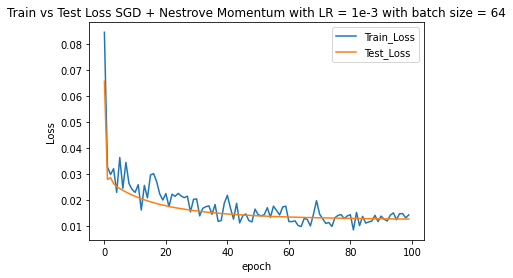

In [59]:
plt.plot(train_loss)
plt.plot(test_loss);
plt.title('Train vs Test Loss'+' '+changeDescription);
plt.xlabel('epoch');
plt.ylabel('Loss');
plt.legend(['Train_Loss','Test_Loss']);
plt.savefig(pltName);

In [60]:
test_inp = torch.Tensor([0.6562, 1.0000, 0.4286, 0.2857, 0.1336, 0.2767, 0.5742, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6360, 0.0511, 0.3145, 0.6621,
        0.0000, 0.0000])

test_op = torch.Tensor([0.4951])
actual    = (test_op*(df_model.Total_score.max() - df_model.Total_score.min() )) + df_model.Total_score.min()
model.eval()
pred     = (model(torch.Tensor(test_inp))*(df_model.Total_score.max() - df_model.Total_score.min() )) + df_model.Total_score.min()
print(f'Predicted Value : {pred.item()} vs Actual value : {actual.item()}')

Predicted Value : 45.327049255371094 vs Actual value : 52.99530029296875


# **9. Record metrics:**

In [61]:
metrics = {
    'pltName'       : [pltName],
    'Model'         : ['nn.Linear(20,1)'],
    'Epochs'        : [epochs],
    'Loss Func'     : [lossFunction],
    'Optimizer'     : ['SGD(model.parameters(),lr=lr)'],
    'LR'            : [lr],
    'Train vs Test BatchSz' : [(train_bs, 2*train_bs)],
    'Train Loss'    : [list(map(lambda x: float(f'{x:.4f}'), train_loss))],
    'Test Loss'     : [list(map(lambda x: float(f'{x:.4f}'), test_loss))],
    'Test Input'    : [test_inp],
    'Actual Score'  : [actual.item()],
    'Predicted'     : [pred.item()],
    'Min_Train_Loss': [min(train_loss)],
    'Min_Test_Loss' : [min(test_loss)],
    'Notes'         : [changeDescription]

}


In [62]:
if record:
    if Path.joinpath(Path.cwd(),recordedMetrics).exists():
        df = pd.read_csv(recordedMetrics)
        print('### Concatinating the Metrics to existing Dataframe')
        df_new = pd.concat([df,pd.DataFrame(metrics)],axis=0)
    else:
        print('### Created a new file')
        df_new = pd.DataFrame(metrics)

    df_new.to_csv(Path.joinpath(Path.cwd(),recordedMetrics),index=False)

### Concatinating the Metrics to existing Dataframe


In [95]:
df = pd.read_csv(recordedMetrics,usecols=['Epochs','LR','Train Loss','Test Loss']) # 'Actual Score', 'Predicted'
df.head()

,Epochs,LR,Train Loss,Test Loss
0,100,0.100,"[0.0309, 0.0313, 0.0268, 0.0282, 0.0136, 0.019...","[0.0242, 0.0213, 0.0196, 0.0168, 0.0187, 0.015..."
1,100,0.100,"[0.0309, 0.0313, 0.0268, 0.0282, 0.0136, 0.019...","[0.0242, 0.0213, 0.0196, 0.0168, 0.0187, 0.015..."
2,100,0.010,"[0.0899, 0.0445, 0.0386, 0.0358, 0.0236, 0.045...","[0.0599, 0.0319, 0.0278, 0.0272, 0.0271, 0.026..."
3,100,0.001,"[0.2511, 0.2024, 0.2031, 0.1445, 0.1704, 0.133...","[0.1999, 0.1722, 0.1486, 0.1291, 0.1123, 0.098..."
4,300,0.001,"[0.2511, 0.2024, 0.2031, 0.1445, 0.1704, 0.133...","[0.1999, 0.1722, 0.1486, 0.1291, 0.1123, 0.098..."


In [124]:
def getMinValue(x):
    return min(list(map(lambda x : x.strip(),x[1:-1].split(','))))

def getMeanValue(x):
    return np.array(list((map(lambda x :float(x.strip()),x[1:-1].split(','))))).mean()

In [126]:
df['Min Test Loss'] = df['Test Loss'].apply(getMinValue)
df['Min Train Loss'] = df['Train Loss'].apply(getMinValue)
df['Mean Train Loss'] = df['Train Loss'].apply(getMeanValue)
df

,Epochs,LR,Train Loss,Test Loss,Min Test Loss,Min Train Loss,Mean Train Loss
0,100,0.100,"[0.0309, 0.0313, 0.0268, 0.0282, 0.0136, 0.019...","[0.0242, 0.0213, 0.0196, 0.0168, 0.0187, 0.015...",0.0117,0.005,0.013183
1,100,0.100,"[0.0309, 0.0313, 0.0268, 0.0282, 0.0136, 0.019...","[0.0242, 0.0213, 0.0196, 0.0168, 0.0187, 0.015...",0.0117,0.005,0.013183
2,100,0.010,"[0.0899, 0.0445, 0.0386, 0.0358, 0.0236, 0.045...","[0.0599, 0.0319, 0.0278, 0.0272, 0.0271, 0.026...",0.014,0.0068,0.020766
3,100,0.001,"[0.2511, 0.2024, 0.2031, 0.1445, 0.1704, 0.133...","[0.1999, 0.1722, 0.1486, 0.1291, 0.1123, 0.098...",0.0249,0.0137,0.045989
4,300,0.001,"[0.2511, 0.2024, 0.2031, 0.1445, 0.1704, 0.133...","[0.1999, 0.1722, 0.1486, 0.1291, 0.1123, 0.098...",0.0192,0.0072,0.031669
5,100,0.100,"[0.1335, 0.208, 0.21, 0.1842, 0.1869, 0.1356, ...","[0.1409, 0.1094, 0.2321, 0.1554, 0.2616, 0.112...",0.0895,0.1145,0.172124
6,100,0.010,"[0.2158, 0.1504, 0.1463, 0.1507, 0.1244, 0.154...","[0.1601, 0.1286, 0.1275, 0.1259, 0.1251, 0.123...",0.0872,0.0517,0.096663
7,100,0.001,"[0.4699, 0.4084, 0.4005, 0.3308, 0.3529, 0.290...","[0.4179, 0.3783, 0.3388, 0.3014, 0.2676, 0.237...",0.1142,0.0895,0.152672
8,100,0.010,"[0.2984, 0.1388, 0.1435, 0.1257, 0.0933, 0.088...","[0.2734, 0.1209, 0.1035, 0.0928, 0.0887, 0.090...",0.0858,0.054,0.089099
9,100,0.010,"[0.1066, 0.0518, 0.0309, 0.0275, 0.0109, 0.019...","[0.1082, 0.0355, 0.0292, 0.0173, 0.0181, 0.015...",0.0119,0.005,0.014071


In [128]:
print(f'### Over all Min Train Loss is : {df["Min Train Loss"].min(axis=0)}')
print(f'### Over all Mean Train Loss is : {df["Mean Train Loss"].min(axis=0)}')



### Over all Min Train Loss is : 0.005
### Over all Mean Train Loss is : 0.011971


0.013183